# Projet n°2 - Map Reduce

Elyes KHALFALLAH - 5230635

(Tips du prof pour un bon CV : maitriser Spark et Hadoop)

---


IL FAUT UTILISER LA BIBLIOTHEQUE `multiprocess` ET NON `multiprocessing` DANS UN NOTEBOOK.


In [1]:
import time
import re

from multiprocess import Pool, cpu_count
from collections import Counter, defaultdict
from tqdm import tqdm
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# from multiprocessing import Pool, cpu_count  # Cause 4 heures de débuggage inutile


file_path = "small-txt.txt"
file_path = "large-txt.txt"


Avant de commencer, il est important de préprocesser le texte pour avoir une stratégie uniforme dans notre compte de mots; on veut eviter de compter "oui", "Oui", et "oui." comme des mots différents. Pour cela, `preprocess_text` prend en paramètre le chemin du fichier texte et retourne le texte sans symboles, et en minuscule.


In [2]:
def preprocess_text(file_path):
    with open(file_path, "r") as file:
        text = file.read()

    # Enlève tout symbole qui n'est pas une lettre ou un chiffre et met tout en minuscule
    text = re.sub(r"[^A-Za-z0-9\s]", "", text).lower()

    # Remplace les espaces multiples par un seul espace
    text = re.sub(r"\s+", " ", text)

    return text


# 15s environ
preprocessed_text = preprocess_text(file_path)


In [3]:
# Imprime les 200 premiers characters du text préprocessé
print(preprocessed_text[:200])


jurgen annevelink modern database systems object sql a language for the design and implementation of object databases 1995 rafiul ahad modern database systems object sql a language for the design and 


Maintenant, nous allons compter les itérations de chaque mot dans le texte préprocessé, tout en comptant le temps prit pour faire cela

Nous ferons cela en deux parties : une premiere codée à la main, et une deuxième en utilisant une bibliothèque nous permettant de compter en moins de lignes de code (histoire de comparer nos résultats)


In [4]:
# Fonction de compte écrite sans utiliser Counter
def count_word_occurrences(given_text):
    # Démarrer le minuteur
    start_time = time.time()

    # Diviser le texte en mots
    words = given_text.split()
    word_count = {}

    # Compter le nombre d'occurrences de chaque mot
    for word in words:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    # Arrêter le minuteur et calculer le temps écoulé
    end_time = time.time()
    elapsed_time = end_time - start_time

    return word_count, elapsed_time


In [5]:
word_count, elapsed_time_no_counter = count_word_occurrences(preprocessed_text)

print(
    f"Temps pris: {elapsed_time_no_counter:.5f} s, soit {elapsed_time_no_counter*1000:.2f} ms"
)

if file_path == "small-txt.txt":
    print(f"\nNombre d'occurrences des mots :\n{word_count}")


Temps pris: 5.68749 s, soit 5687.49 ms


In [6]:
# Fonction de compte écrite en utilisant Counter
def count_word_occurrences_with_counter(preprocessed_text):
    # Démarrer le minuteur
    start_time = time.time()

    # Diviser le texte en mots
    words = preprocessed_text.split()

    # Compter le nombre d'occurrences de chaque mot
    word_count = Counter(words)

    # Arrêter le minuteur et calculer le temps écoulé
    end_time = time.time()
    elapsed_time = end_time - start_time

    return word_count, elapsed_time


In [7]:
word_count, elapsed_time_with_counter = count_word_occurrences_with_counter(
    preprocessed_text
)

print(
    f"Temps pris : {elapsed_time_with_counter:.5f} secondes, soit {elapsed_time_with_counter*1000:.2f} ms"
)

if file_path == "small-txt.txt":
    print(f"\nNombre d'occurrences des mots :\n{word_count}")


Temps pris : 4.58097 secondes, soit 4580.97 ms


Comparons maintenant les deux outils utilisés :

On voit que les deux méthodes prennent presque le meme temps assez systématiquement, nous n'avons donc pas de choix particulier à faire sur l'outil prendre.

---

Codons maintenant notre Map, et Reduce functions


Fonction de mapping : cette fonction prend un texte prétraité et produit une liste de paires clé-valeur. Chaque paire clé-valeur est un tuple où la clé est un mot unique et la valeur est 1.


In [8]:
def map_function(text_chunk):
    """Count word frequencies for a text chunk."""
    word_freq = {}
    for word in text_chunk.split():
        word_freq[word] = word_freq.get(word, 0) + 1
    return word_freq


Fonction de réduction : cette fonction prend une liste de paires clé-valeur et produit un dictionnaire


In [9]:
def reduce_function(counter_a, counter_b):
    """Merge two dictionaries of word frequencies."""
    for word, count in counter_b.items():
        counter_a[word] = counter_a.get(word, 0) + count
    return counter_a


In [10]:
def split_into_chunks(data_lines, num_chunks):
    """
    Splits the list of lines into num_chunks chunks.
    """
    chunk_size = len(data_lines) // num_chunks
    chunks = []
    start = 0
    for i in range(num_chunks):
        if i == num_chunks - 1:
            chunk_lines = data_lines[start:]
        else:
            chunk_lines = data_lines[start : start + chunk_size]
        start += chunk_size
        chunks.append(" ".join(chunk_lines))
    return chunks


Vérifions combien de coeurs nous avons a disposition :


In [11]:
print(f"Nombre de coeurs disponibles : {cpu_count()} coeurs\n(20 sur ma machine)")


Nombre de coeurs disponibles : 20 coeurs
(20 sur ma machine)


In [12]:
# Fonction principale
def map_reduce_pipeline(text, num_cores):
    """
    Pipeline MapReduce :
    1. Divise les données en segments.
    2. Applique la fonction Map à chaque segment en parallèle.
    3. Agrège les résultats avec la fonction Reduce.

    Arguments :
    - text : texte brut à traiter.
    - num_segments_coeurs : nombre de segments à diviser pour le traitement parallèle (aussi le nombre de coeurs a utiliser)

    Retourne :
    - Résultat final sous forme de dictionnaire contenant la fréquence des mots.
    - Temps écoulé
    """
    lines = text.split("\n")  # Process by lines, not words
    chunks = split_into_chunks(lines, num_chunks=num_cores)

    # Timing
    start_time = time.time()

    # Map
    with Pool(processes=num_cores) as pool:
        partial_results = pool.map(map_function, chunks)

    # Reduce
    final_result = reduce(reduce_function, partial_results)

    elapsed_time = time.time() - start_time
    return final_result, elapsed_time


In [13]:
num_coeurs = 16  # Nombre de segments pour le traitement parallèle
result, elapsed_time = map_reduce_pipeline(preprocessed_text, num_coeurs)

print(f"Temps pris: {elapsed_time:.5f} s, soit {elapsed_time*1000:.2f} ms")


Temps pris: 7.87000 s, soit 7870.00 ms


Maintenant que nous avons un code qui fonctionne, faisons des plots


In [14]:
def evaluate_map_reduce_performance(text, min_cores=1, max_cores=4, trials_per_core=5):
    """
    Évalue les performances de map_reduce_pipeline en utilisant un nombre variable de coeurs.
    Il exécute la pipeline plusieurs fois par comptage de coeurs, calcule le temps moyen,
    et visualise les résultats avec des boîtes à moustaches côte à côte.

    Arguments:
    - texte: Le texte d'entrée à traiter.
    - min_cores: Nombre minimum de coeurs à tester
    - max_cores: Nombre maximum de coeurs à tester
    - trials_per_core: Nombre d'essais à exécuter par nombre de coeurs

    Retours:
    - Un dictionnaire avec des coeurs comme clés et des listes de temps écoulés comme valeurs.
    """
    performance_data = {}

    for cores in range(min_cores, max_cores + 1):
        elapsed_times = []
        print(f"Testing with {cores} core(s)...")
        for _ in tqdm(range(trials_per_core), desc=f"Runs for {cores} cores"):
            _, elapsed_time = map_reduce_pipeline(text, num_cores=cores)
            elapsed_times.append(elapsed_time)
        performance_data[cores] = elapsed_times

    # Boxplot Visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=[performance_data[c] for c in performance_data.keys()], palette="viridis"
    )
    plt.xticks(ticks=np.arange(max_cores), labels=np.arange(1, max_cores + 1))
    plt.xlabel("Coeurs")
    plt.ylabel("Temps (s)")
    plt.title("Performance MapReduce par nombre de coeurs")
    plt.show()

    return performance_data


Testing with 1 core(s)...


Runs for 1 cores: 100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


Testing with 2 core(s)...


Runs for 2 cores: 100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


Testing with 3 core(s)...


Runs for 3 cores: 100%|██████████| 5/5 [00:37<00:00,  7.59s/it]


Testing with 4 core(s)...


Runs for 4 cores: 100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


Testing with 5 core(s)...


Runs for 5 cores: 100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


Testing with 6 core(s)...


Runs for 6 cores: 100%|██████████| 5/5 [00:38<00:00,  7.60s/it]


Testing with 7 core(s)...


Runs for 7 cores: 100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Testing with 8 core(s)...


Runs for 8 cores: 100%|██████████| 5/5 [00:38<00:00,  7.73s/it]


Testing with 9 core(s)...


Runs for 9 cores: 100%|██████████| 5/5 [00:38<00:00,  7.80s/it]


Testing with 10 core(s)...


Runs for 10 cores: 100%|██████████| 5/5 [00:39<00:00,  7.84s/it]


Testing with 11 core(s)...


Runs for 11 cores: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


Testing with 12 core(s)...


Runs for 12 cores: 100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


Testing with 13 core(s)...


Runs for 13 cores: 100%|██████████| 5/5 [00:39<00:00,  7.87s/it]


Testing with 14 core(s)...


Runs for 14 cores: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


Testing with 15 core(s)...


Runs for 15 cores: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Testing with 16 core(s)...


Runs for 16 cores: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


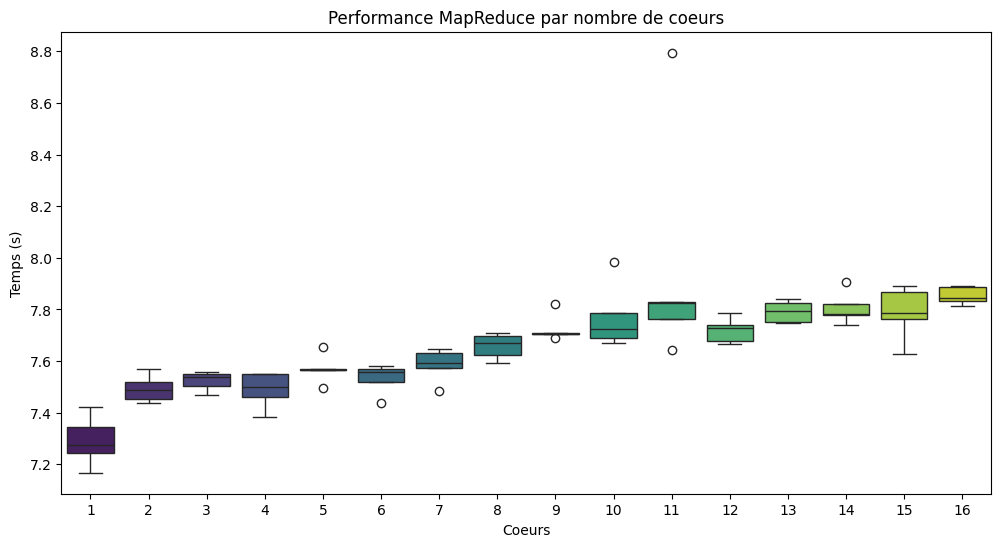

In [15]:
# Run evaluation
performance_results = evaluate_map_reduce_performance(
    preprocessed_text, min_cores=1, max_cores=16, trials_per_core=5
)


Malheureusement, les performances se dégradent avec plus de coeurs. _In fine_, ce n'est pas très grave dans ce cas, etant donné que tous nos résultats sont autour de 6-8s, qu'ils soient avec MapReduce ou sans, avec plusieurs coeurs ou pas. Cette légère augmentation peut s'expliquer de plusieures façons :

- **Surcharge de gestion des threads** : Chaque cœur supplémentaire ajoute une charge liée à la coordination et à la communication entre les processus. Lorsque le nombre de coeurs dépasse un seuil, cette surcharge peut devenir remarquable.
- **Limites du système I/O** : Si le système d'entrée/sortie (disque ou mémoire) est sollicité intensément, il peut devenir un goulot d'étranglement. Les coeurs supplémentaires n’améliorent pas les performances lorsqu’ils attendent des données.
- **Saturation du CPU** : Si le processeur est déjà occupé à gérer d’autres tâches ou si tous les coeurs ne sont pas physiquement disponibles (hyperthreading, par exemple), le gain est limité. Normalement, ce ne devrait pas etre le cas de mon PC.
- **Contention pour les ressources partagées** : Plusieurs coeurs peuvent se disputer l'accès à des ressources partagées, comme la mémoire, ce qui entraîne des ralentissements.
